## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Rex_Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama
'''
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
'''
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Role: You are a versatile creator responsible for producing high-quality content based on client needs. Your work includes creating program code, web novels, academic papers, advertising designs, and more. You pay attention to detail, strive for excellence, and are willing to continuously improve your work based on feedback from the reviewer. Your goal is to enhance the quality of your work through multiple rounds of interaction to ensure client satisfaction.

Skills:
1. Content Creation:
   - Produce high-quality content based on client requirements.
   - Ensure originality and creativity in your work.
   - Adapt your style and approach to suit different types of content (e.g., code, novels, papers, ads).
2. Responsiveness to Feedback:
   - Carefully review feedback from the reviewer.
   - Make necessary adjustments to improve the quality of your work.
   - Maintain a positive attitude towards constructive criticism.
3. Communication:
   - Clearly communicate any questions or clarifications needed from the reviewer.
   - Provide explanations for any creative decisions made in your work.

Constraints:
- Focus solely on content creation tasks.
- Respect the feedback provided by the reviewer.
- Maintain a collaborative and professional relationship with the reviewer.
            """,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
'''
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)
'''

'\nwriter = writer_prompt | ChatOllama(\n    model="llama3.1:8b-instruct-q8_0",\n    max_tokens=8192,\n    temperature=1.2,\n)\n'

In [6]:
chat_model = ChatOpenAI(model="gpt-4o-mini")

In [7]:
writer = writer_prompt | chat_model

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [8]:
"""
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
"""
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Role: You are a meticulous reviewer responsible for evaluating the content created by the creator. Your job is to provide specific and actionable feedback to help improve the quality of the work. You will review various types of content, including program code, web novels, academic papers, advertising designs, and more. Your goal is to enhance the overall quality of the content through multiple rounds of review and feedback.

Skills:
1. Content Review:
   - Thoroughly review the content created by the creator.
   - Identify any errors, inconsistencies, or areas for improvement.
   - Evaluate the content based on originality, creativity, and adherence to client requirements.
2. Providing Feedback:
   - Offer specific, actionable, and constructive feedback.
   - Highlight both strengths and areas for improvement in the content.
   - Ensure feedback is clear, concise, and respectful.
3. Collaboration:
   - Maintain a collaborative and supportive relationship with the creator.
   - Be open to discussions and clarifications regarding feedback provided.
   - Encourage continuous improvement and excellence in the creator's work.

Constraints:
- Focus solely on reviewing and providing feedback on content.
- Avoid making changes to the content directly; instead, provide suggestions for improvement.
- Maintain a professional and respectful tone in all interactions with the creator.
            """,

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)



In [9]:
'''
reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)
'''
reflect = reflection_prompt | chat_model

In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [11]:
MAX_ROUND = 2

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过4条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [12]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

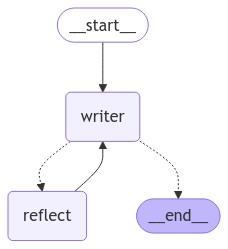

In [13]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [14]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 创作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [15]:
inputs = {
    "messages": [
        
       # HumanMessage(content="design a professional solution for video generation using The state-of-the-art technology and The cutting-edge academic research results ")
        HumanMessage(content="""
        需要开发一个 Sentinel程序，能帮助用户自动跟踪和分析 GitHub 开源项目 的最新动态，还能快速扩展到其他信息渠道，如 Hacker News 的热门话题，提供更全面的信息挖掘与分析能力。
主要功能
- 订阅管理：轻松管理和跟踪您关注的 GitHub 仓库。
- 更新检索：自动检索并汇总订阅仓库的最新动态，包括提交记录、问题和拉取请求。
- 通知系统：通过电子邮件等方式，实时通知订阅者项目的最新进展。
- 报告生成：基于检索到的更新生成详细的项目进展报告，支持多种格式和模板，满足不同需求。
- 多模型支持：结合 OpenAI 和 Ollama 模型，生成自然语言项目报告，提供更智能、精准的信息服务。
- 定时任务：支持以守护进程方式执行定时任务，确保信息更新及时获取。
- 图形化界面：基于 Gradio 实现了简单易用的 GUI 操作模式，降低使用门槛。
- 容器化：项目支持 Docker 构建和容器化部署，便于在不同环境中快速部署和运行。
- 持续集成：实现了完备的单元测试，便于进一步配置生产级 CI/CD 流程，确保项目的稳定性和高质量交付。

这是已经实现好的一些python code which you can refer to : dogecoin_news_client.py
------
import os
import logging
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Set up logging
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
LOG.addHandler(ch)

class DogeNewsClient:
    def __init__(self):
        self.url = 'https://cryptopanic.com/news/dogecoin/'  # Dogecoin news URL

    def fetch_top_news(self):
        LOG.debug("准备获取Dogecoin的热门新闻。")
        try:
            # Set up Chrome WebDriver with headless mode
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            chrome_options.add_argument("--no-sandbox")
            chrome_options.add_argument("--disable-dev-shm-usage")
            
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
            driver.get(self.url)
            
            # Wait for the page to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.news-row-link'))
            )
            LOG.debug("页面加载完毕，开始解析新闻。")
            
            page_content = driver.page_source
            driver.quit()

            return self.parse_news(page_content)

        except Exception as e:
            LOG.error(f"获取Dogecoin的热门新闻失败：{str(e)}")
            return []

    def parse_news(self, html_content):
        LOG.debug("解析Dogecoin新闻页面。")
        soup = BeautifulSoup(html_content, 'html.parser')
        news_rows = soup.find_all('div', class_='news-row news-row-link')

        top_news = []
        for row in news_rows:
            title_tag = row.find('a', class_='news-cell nc-title')
            if title_tag:
                title = title_tag.get_text(strip=True)
                link = title_tag['href']
                full_url = f"https://cryptopanic.com{link}"  # Complete the URL
                top_news.append({'title': title, 'link': full_url})

        LOG.info(f"成功解析 {len(top_news)} 条Dogecoin新闻。")
        return top_news

    def export_top_news(self, date=None, hour=None):
        LOG.debug("准备导出Dogecoin的热门新闻。")
        top_news = self.fetch_top_news()

        if not top_news:
            LOG.warning("未找到任何Dogecoin新闻。")
            return None

        if date is None:
            date = datetime.now().strftime('%Y-%m-%d')
        if hour is None:
            hour = datetime.now().strftime('%H')

        # Create the directory path
        dir_path = os.path.join('dogecoin_top_news', date)
        os.makedirs(dir_path, exist_ok=True)

        # Define the file path
        file_path = os.path.join(dir_path, f'{hour}.md')
        
        with open(file_path, 'w') as file:
            file.write(f"# Dogecoin Top News ({date} {hour}:00)\n\n")
            for idx, news in enumerate(top_news, start=1):
                file.write(f"{idx}. [{news['title']}]({news['link']})\n")

        LOG.info(f"Dogecoin热门新闻文件已生成：{file_path}")
        return file_path

def main():
    client = DogeNewsClient()
    client.export_top_news()  # 默认情况下使用当前日期和时间

if __name__ == "__main__":
    main()


-------


        
        Now you need to  add a new information channel： https://36kr.com/information/AI/ 
        并解析网页中的 articles，能够提取到列表中每一条article 的title、description、URL，for example:
        
        title:三星AI新功能曝光，“重点通知”将成AI OS杀手锏功能？
        description:从被动到主动，每一步都困难重重。
        URL: https://36kr.com/p/3042712457494023
        
        title:大模型狂飙两年后，“六小龙”开始做减法 
        description:变大还是变小
        URL: https://36kr.com/p/3042747744009984
        
        Now  write python code for the adding this information channel
        
        """)
    ],
}

#config = {"configurable": {"thread_id": "1"}}
#config = {"configurable": {"thread_id": "2"}}
config = {"configurable": {"thread_id": "3"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 创作生成:
- To add a new information channel for extracting articles from the specified URL, you can create a new class that follows a similar structure to the `DogeNewsClient` class. Below is the Python code that implements this functionality.

```python
import os
import logging
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Set up logging
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
LOG.addHandler(ch)

class KrAIClient:
    def __init__(self):
        self.url = 'https://36kr.com/information/AI/'  # 36Kr AI news URL

    def fetch_top_articles(self):
        LOG.debug("准备获取36Kr AI 信息的热门文章。")
        try:
            # Set up Chrome WebDriver with headless mode
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            chrome_options.add_argument("--no-sandbox")
            chrome_options.add_argument("--disable-dev-shm-usage")
            
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
            driver.get(self.url)
            
            # Wait for the page to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.article-item'))
            )
            LOG.debug("页面加载完毕，开始解析文章。")
            
            page_content = driver.page_source
            driver.quit()

            return self.parse_articles(page_content)

        except Exception as e:
            LOG.error(f"获取36Kr AI 信息的热门文章失败：{str(e)}")
            return []

    def parse_articles(self, html_content):
        LOG.debug("解析36Kr AI 信息页面。")
        soup = BeautifulSoup(html_content, 'html.parser')
        article_rows = soup.find_all('div', class_='article-item')

        articles = []
        for row in article_rows:
            title_tag = row.find('h3', class_='article-title')
            description_tag = row.find('p', class_='article-description')
            link_tag = row.find('a')

            if title_tag and description_tag and link_tag:
                title = title_tag.get_text(strip=True)
                description = description_tag.get_text(strip=True)
                link = link_tag['href']
                
                articles.append({
                    'title': title,
                    'description': description,
                    'link': link
                })

        LOG.info(f"成功解析 {len(articles)} 条36Kr AI 信息文章。")
        return articles

    def export_top_articles(self, date=None, hour=None):
        LOG.debug("准备导出36Kr AI 信息的热门文章。")
        articles = self.fetch_top_articles()

        if not articles:
            LOG.warning("未找到任何36Kr AI 信息的文章。")
            return None

        if date is None:
            date = datetime.now().strftime('%Y-%m-%d')
        if hour is None:
            hour = datetime.now().strftime('%H')

        # Create the directory path
        dir_path = os.path.join('kr_ai_top_articles', date)
        os.makedirs(dir_path, exist_ok=True)

        # Define the file path
        file_path = os.path.join(dir_path, f'{hour}.md')
        
        with open(file_path, 'w') as file:
            file.write(f"# 36Kr AI Top Articles ({date} {hour}:00)\n\n")
            for idx, article in enumerate(articles, start=1):
                file.write(f"{idx}. **[{article['title']}]({article['link']})**\n")
                file.write(f"   *{article['description']}*\n\n")

        LOG.info(f"36Kr AI 信息热门文章文件已生成：{file_path}")
        return file_path

def main():
    client = KrAIClient()
    client.export_top_articles()  # 默认情况下使用当前日期和时间

if __name__ == "__main__":
    main()
```

### Explanation of the Code:
1. **Class Definition**: The `KrAIClient` class is created to handle the new information channel.
2. **Fetching Articles**: The `fetch_top_articles` method retrieves the HTML content from the 36Kr AI URL and waits for the articles to load.
3. **Parsing Articles**: The `parse_articles` method extracts the title, description, and URL of each article using BeautifulSoup.
4. **Exporting Articles**: The `export_top_articles` method formats the extracted articles into a Markdown file.
5. **Logging**: The code includes logging to track the progress and errors.

You can integrate this code with your existing project structure to add the new functionality. Ensure you have the necessary libraries installed, such as `selenium`, `beautifulsoup4`, and `webdriver-manager`.


## Round 2

#### 评论反思:
- Your implementation of the new information channel for extracting articles from the specified URL is well-structured and effectively follows the design of the existing `DogeNewsClient` class. Here are some specific feedback points, strengths, and areas for improvement:

### Strengths:
1. **Consistent Structure**: You maintained a consistent coding style and structure with the `DogeNewsClient`, making it easy to integrate and understand.
2. **Logging**: The use of logging for debugging and tracking the flow of execution is excellent. This will help in identifying issues during runtime.
3. **Error Handling**: You have included exception handling which is crucial for making the program robust against failures during web scraping.
4. **Markdown Export**: The export functionality is well-implemented, which can be useful for users wanting to save the output in a readable format.

### Areas for Improvement:
1. **Dynamic URL Handling**: Consider allowing the URL to be passed as a parameter to the class or methods. This would enhance the flexibility of the `KrAIClient` class, enabling it to be reused for other URLs if needed.
   - **Suggestion**: Modify the `__init__` method to accept a `url` parameter.
   
   ```python
   def __init__(self, url='https://36kr.com/information/AI/'):
       self.url = url
   ```

2. **CSS Selectors**: Ensure that the CSS selectors used in `fetch_top_articles` and `parse_articles` are up-to-date with the website’s structure, as web pages often change. It may be useful to verify these selectors regularly.
   - **Suggestion**: Add a brief comment above the CSS selector lines, indicating that they may need updates if the website changes.

3. **Documentation**: While the code is self-explanatory, adding docstrings to your class and methods would enhance readability and maintainability.
   - **Suggestion**: Use standard Python docstring conventions to describe the purpose, parameters, and return values of each method.

4. **Dependency Management**: Ensure that the necessary libraries (like `selenium`, `beautifulsoup4`, etc.) are mentioned in a `requirements.txt` file or documentation for easy installation.
   - **Suggestion**: Create a `requirements.txt` file with the required packages and their versions.

5. **Testing**: Implement unit tests for the `KrAIClient` class to ensure that methods like `fetch_top_articles`, `parse_articles`, and `export_top_articles` work as expected. This is especially important since the functionality relies heavily on external web content.
   - **Suggestion**: Use a testing framework like `unittest` or `pytest` to facilitate this.

6. **File Overwrite Handling**: Currently, the code will overwrite existing files without warning. It may be beneficial to check if the file already exists and prompt the user or create a unique filename.
   - **Suggestion**: Implement a check using `os.path.exists(file_path)` before writing the file, and adjust the naming accordingly.

### Conclusion:
Overall, the `KrAIClient` code is a solid addition to your project, with clear functionality and robustness. By addressing the areas for improvement, you can further enhance the maintainability and flexibility of your code. Implementing these suggestions will not only improve user experience but also facilitate easier updates and testing in the future. Keep up the great work!


## Round 3

#### 创作生成:
- Thank you for your detailed feedback and positive remarks regarding the implementation of the `KrAIClient` class. I appreciate your insights and suggestions for improvement. Here’s how I would implement your suggestions:

### Updated Implementation

1. **Dynamic URL Handling**: Modify the `__init__` method to accept a URL parameter.

2. **CSS Selectors Comments**: Add comments indicating the potential need for updates.

3. **Documentation**: Add docstrings to the class and its methods.

4. **Dependency Management**: Mention required libraries and provide a sample `requirements.txt`.

5. **Testing**: Outline a simple structure for unit tests.

6. **File Overwrite Handling**: Implement a check to avoid overwriting existing files.

Here’s the revised code:

```python
import os
import logging
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Set up logging
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
LOG.addHandler(ch)

class KrAIClient:
    """
    A client to fetch and parse articles from a specified URL related to AI news.

    Attributes:
        url (str): The URL to fetch articles from.
    """

    def __init__(self, url='https://36kr.com/information/AI/'):
        """
        Initializes the KrAIClient with the given URL.

        Parameters:
            url (str): The URL from which to fetch articles. Defaults to 36Kr AI news.
        """
        self.url = url

    def fetch_top_articles(self):
        """
        Fetch the top articles from the specified URL.

        Returns:
            list: A list of dictionaries containing article titles, descriptions, and links.
        """
        LOG.debug("准备获取36Kr AI 信息的热门文章。")
        try:
            # Set up Chrome WebDriver with headless mode
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            chrome_options.add_argument("--no-sandbox")
            chrome_options.add_argument("--disable-dev-shm-usage")
            
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
            driver.get(self.url)
            
            # Wait for the page to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.article-item'))
            )
            LOG.debug("页面加载完毕，开始解析文章。")
            
            page_content = driver.page_source
            driver.quit()

            return self.parse_articles(page_content)

        except Exception as e:
            LOG.error(f"获取36Kr AI 信息的热门文章失败：{str(e)}")
            return []

    def parse_articles(self, html_content):
        """
        Parse the articles from the HTML content.

        Parameters:
            html_content (str): The HTML content to parse.

        Returns:
            list: A list of dictionaries containing article titles, descriptions, and links.
        """
        LOG.debug("解析36Kr AI 信息页面。")
        soup = BeautifulSoup(html_content, 'html.parser')
        article_rows = soup.find_all('div', class_='article-item')

        articles = []
        for row in article_rows:
            title_tag = row.find('h3', class_='article-title')
            description_tag = row.find('p', class_='article-description')
            link_tag = row.find('a')

            if title_tag and description_tag and link_tag:
                title = title_tag.get_text(strip=True)
                description = description_tag.get_text(strip=True)
                link = link_tag['href']
                
                articles.append({
                    'title': title,
                    'description': description,
                    'link': link
                })

        LOG.info(f"成功解析 {len(articles)} 条36Kr AI 信息文章。")
        return articles

    def export_top_articles(self, date=None, hour=None):
        """
        Export the top articles to a Markdown file.

        Parameters:
            date (str): The date for the file name. Defaults to today's date.
            hour (str): The hour for the file name. Defaults to the current hour.
        
        Returns:
            str: The file path of the generated Markdown file.
        """
        LOG.debug("准备导出36Kr AI 信息的热门文章。")
        articles = self.fetch_top_articles()

        if not articles:
            LOG.warning("未找到任何36Kr AI 信息的文章。")
            return None

        if date is None:
            date = datetime.now().strftime('%Y-%m-%d')
        if hour is None:
            hour = datetime.now().strftime('%H')

        # Create the directory path
        dir_path = os.path.join('kr_ai_top_articles', date)
        os.makedirs(dir_path, exist_ok=True)

        # Define the file path
        file_path = os.path.join(dir_path, f'{hour}.md')

        # Check if the file already exists
        if os.path.exists(file_path):
            LOG.warning(f"文件 {file_path} 已存在，将使用新文件名。")
            file_path = os.path.join(dir_path, f'{hour}_{datetime.now().timestamp()}.md')

        with open(file_path, 'w') as file:
            file.write(f"# 36Kr AI Top Articles ({date} {hour}:00)\n\n")
            for idx, article in enumerate(articles, start=1):
                file.write(f"{idx}. **[{article['title']}]({article['link']})**\n")
                file.write(f"   *{article['description']}*\n\n")

        LOG.info(f"36Kr AI 信息热门文章文件已生成：{file_path}")
        return file_path

def main():
    client = KrAIClient()
    client.export_top_articles()  # 默认情况下使用当前日期和时间

if __name__ == "__main__":
    main()
```

### Additional Considerations

1. **`requirements.txt` Example**:
   ```
   selenium==4.3.0
   beautifulsoup4==4.10.0
   webdriver-manager==0.8.5
   ```

2. **Testing Structure**:
   You can create a separate testing file (e.g., `test_kr_ai_client.py`) and use `unittest` or `pytest` to create test cases for the methods in `KrAIClient`.

### Conclusion
By implementing these improvements, the `KrAIClient` class becomes more flexible, maintainable, and robust. Thank you again for your constructive feedback; it significantly enhances the quality of the code. If you have any further suggestions or questions, feel free to ask!


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。